# LSTM 주가 예측 example

- 1. 데이터 로드 및 분포 확인 \
가. df=pd.read_csv(), df.decrvbe(), df.hist(), plot() 등
- 2. 데이터 전처리\
가. outlier/missing value 확인 후 대체(또는 삭제) 처리 \
나. 데이터 정규화(normalization)/표준화(standardization)\
다. 딥러닝 학습을 위한 feature column/label column 정의
- 3. 데이터 생성\
가. window size 설정 후 feature/label 시계열 데이터 생성\
나. 학습 데이터 생성, 이 때 입력 데이터는 (batch size, time steps, input dims) 형태의 3차원 텐서로 생성되어야 함.
- 4. 순환 신경망 모델 구축 및 학습

## 데이터 로드 및 분포 확인

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [2]:
raw_df = pd.read_csv('./005930.KS_3MA_5MA.csv') 
# 삼성전자 주식가격 (00.01.04 ~ 21.06.18)
# yahoo finance 로부터 데이터 다운로드
# 정확도를 높이기 위해 3일 이동 평균선(3MA), 5일 이동평균선(5MA) 데이터 추가

raw_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4740.119629,74195000.0,NaN,NaN
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4328.947754,74680000.0,NaN,NaN
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4359.979492,54390000.0,4476.348958,NaN
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4297.916992,40305000.0,4328.948079,NaN
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4476.349121,46880000.0,4378.081868,4440.662598


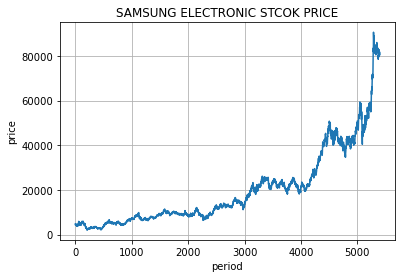

In [3]:
plt.title('SAMSUNG ELECTRONIC STCOK PRICE')
plt.ylabel('price')
plt.xlabel('period')
plt.grid()

plt.plot(raw_df['Adj Close'], label='Adj Close')

plt.show()

## 데이터 전처리 - Outlier 확인
- 통계적으로 비정상적으로 크거나 작은 데이터인 outlier(특이값)는 딥러닝 학습을 하기 위해서는\
적절한 값으로 바꾸거나 삭제하는 등의 처리가 반드시 필요함.

In [4]:
raw_df.describe()

# 판다스 describe()를 통해서 삼성전자 주가 데이터 통계를 확인해보면, 
# 거래량을 나타내는 Volume 최소값이 0 임을 알 수 있음
# => 주식과 같은 금융데이터에서 Volume(거래량) 값이 없는, 
# 즉 0으로 나타나는 곳은 missing value(결측값)인 NAN으로 취급하는 것이 일반적임

,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
count,5389.000000,5389.000000,5389.000000,5389.000000,5389.000000,5.389000e+03,5393.000000,5391.000000
mean,22801.887178,23043.991464,22559.285582,22801.909445,19920.044863,2.207838e+07,19934.224878,19925.585966
std,17736.201238,17906.827402,17572.109940,17733.296811,17322.636387,1.564053e+07,17313.297249,17292.697383
min,2540.000000,2760.000000,2420.000000,2730.000000,2117.926025,0.000000e+00,2164.473877,2179.989746
25%,9880.000000,9990.000000,9800.000000,9900.000000,7726.937988,1.185265e+07,7726.939453,7709.871631
50%,15760.000000,15940.000000,15560.000000,15800.000000,12808.596680,1.803935e+07,12802.806970,12809.314840
75%,29280.000000,29560.000000,29000.000000,29280.000000,24566.556640,2.771475e+07,24558.166020,24555.269140
max,90300.000000,96800.000000,89500.000000,91000.000000,90597.414060,1.642150e+08,90033.252600,89562.014060


In [5]:
for col in raw_df.columns:

    if raw_df[col].min() == 0:
        col_name = col
        print(col_name, type(col_name))

Volume <class 'str'>


## 데이터 전처리 - Missing Value 확인
- 결측치(missing value)는 특정 데이터가 누락된 것을 말하며,\
outlier와 마찬가지로 이러한 missing value를 제거하거나 적절한 값으로 대체하는 등의 처리가 필요함

In [6]:
raw_df.loc[raw_df['Volume']==0]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
23,2000-02-04,5130.0,5130.0,5130.0,5130.0,3979.839355,0.0,4010.871419,4097.760644
41,2000-03-01,5120.0,5120.0,5120.0,5120.0,3972.081543,0.0,3889.329834,3914.672510
66,2000-04-05,6800.0,6800.0,6800.0,6800.0,5275.420410,0.0,5353.000163,5345.242773
72,2000-04-13,6910.0,6910.0,6910.0,6910.0,5360.757324,0.0,5409.891439,5495.746680
84,2000-05-01,6000.0,6000.0,6000.0,6000.0,4654.781250,0.0,4499.622070,4443.765039
...,...,...,...,...,...,...,...,...,...
4623,2018-04-30,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47560.473960,46736.421880
4624,2018-05-02,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47194.763280
4625,2018-05-03,53000.0,53000.0,53000.0,53000.0,47819.117190,0.0,47819.117190,47663.931250
5077,2020-03-09,56500.0,56500.0,56500.0,56500.0,53774.468750,0.0,54186.897140,53983.855470


In [7]:
for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 116
3MA: 0
5MA: 0


## 데이터 전처리 - Outlier 및 Missing Value 처리
### - Volume 값 0을 NAN 으로 모두 대체

In [8]:
# 먼저 0 을 NaN 으로 바꾼후, Missing Data 처리

raw_df['Volume'] = raw_df['Volume'].replace(0, np.nan)

# 각 column에 0 몇개인지 확인

for col in raw_df.columns:

    missing_rows = raw_df.loc[raw_df[col]==0].shape[0]
    print(col + ': ' + str(missing_rows))

Date: 0
Open: 0
High: 0
Low: 0
Close: 0
Adj Close: 0
Volume: 0
3MA: 0
5MA: 0


### - 모든 Missing Value 삭제

In [9]:
raw_df.isnull().sum()

Date           0
Open           6
High           6
Low            6
Close          6
Adj Close      6
Volume       122
3MA            2
5MA            4
dtype: int64

In [10]:
raw_df.isnull().any()

Date         False
Open          True
High          True
Low           True
Close         True
Adj Close     True
Volume        True
3MA           True
5MA           True
dtype: bool

In [11]:
raw_df.loc[raw_df['Open'].isna()]

,Date,Open,High,Low,Close,Adj Close,Volume,3MA,5MA
1304,2005-01-03,NaN,NaN,NaN,NaN,NaN,NaN,6989.931152,6910.412353
4513,2017-11-16,NaN,NaN,NaN,NaN,NaN,NaN,49382.673830,49719.997070
4518,2017-11-23,NaN,NaN,NaN,NaN,NaN,NaN,49373.792970,49324.969730
4542,2018-01-02,NaN,NaN,NaN,NaN,NaN,NaN,44927.763670,44190.302730
4755,2018-11-15,NaN,NaN,NaN,NaN,NaN,NaN,40569.835940,40775.886720
5000,2019-11-14,NaN,NaN,NaN,NaN,NaN,NaN,49695.419920,49364.432620


In [12]:
raw_df = raw_df.dropna()

raw_df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
3MA          0
5MA          0
dtype: int64

## 데이터 전처리 - 정규화(Normalization)
- 딥러닝 하습이 잘되기 위해서는 정규화 작업이 필요함.
- 즉, 날짜를 나타내는 Date 항목을 제외한 숫자로 표현되는 모든 column에 대해서 0~1 값으로 정규화 수행함

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close','3MA', '5MA', 'Volume']
# 정규화 대상 column 영역

scaled_df = scaler.fit_transform(raw_df[scale_cols]) # 정규화 수행

scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) # 정규화된 새로운 DataFrame생성

print(scaled_df)

          Open      High       Low     Close  Adj Close       3MA       5MA  \
0     0.034868  0.032008  0.036288  0.034440   0.026655  0.025192  0.025698   
1     0.037375  0.035517  0.038470  0.034440   0.026655  0.025634  0.025094   
2     0.034982  0.031689  0.036518  0.033873   0.026217  0.026163  0.025343   
3     0.034868  0.031689  0.036059  0.033760   0.026129  0.025987  0.025503   
4     0.036235  0.033177  0.037437  0.035120   0.027181  0.026163  0.026018   
...        ...       ...       ...       ...        ...       ...       ...   
5264  0.891750  0.830923  0.896647  0.881047   0.885878  0.895299  0.903144   
5265  0.892890  0.834113  0.897795  0.885578   0.890399  0.894920  0.900854   
5266  0.899727  0.841557  0.903537  0.895774   0.900571  0.897955  0.902457   
5267  0.895169  0.835177  0.898944  0.885578   0.890399  0.899472  0.902228   
5268  0.895169  0.833050  0.896647  0.881047   0.885878  0.897955  0.901083   

        Volume  
0     0.285359  
1     0.363715  


In [14]:
def make_sequene_dataset(feature, label, window_size):

    feature_list = []      # 생성될 feature list
    label_list = []        # 생성될 label list

    for i in range(len(feature)-window_size):

        feature_list.append(feature[i:i+window_size])
        label_list.append(label[i+window_size])

    return np.array(feature_list), np.array(label_list)

## 데이터 전처리 - feature column / label column 정의
- 딥러닝 학습을 위한 입력데이터 feature column, 정답데이터 label column 정의 후\
numpy로 변환하여 데이터 전처리 과정을 완료함

In [15]:
feature_cols = [ '3MA', '5MA', 'Adj Close' ] # feature 정의 (입력데이터)
label_cols = [ 'Adj Close' ] # label 정의 (정답데이터)

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

In [16]:
feature_np = feature_df.to_numpy() # 딥러닝 학습을 위해 DataFrame -> numpy 변환
label_np = label_df.to_numpy()

print(feature_np.shape, label_np.shape)

(5269, 3) (5269, 1)


## 데이터 생성 - 입력데이터 feature / 정답데이터 label
### 1. 학습 데이터 X,Y 생성

In [17]:
window_size = 40

# 입력 파라미터 feature, label => numpy type
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

print(X.shape, Y.shape)

(5229, 40, 3) (5229, 1)


## 데이터 분리 및 모델구축
### 2. 트레이닝 데이터 / 테스트 데이터 분리

In [18]:
split = -200

x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5029, 40, 3) (5029, 1)
(200, 40, 3) (200, 1)


### 3. LSTM 모델 구축

In [19]:
model = Sequential()

model.add(LSTM(128, activation='tanh', input_shape=x_train[0].shape))
# LSTM 계층에 tanh를 활성화 함수로 가지는 노드 수 128개, input_shape=(40,3)

model.add(Dense(1, activation='linear'))

## 모델 컴파일 및 학습
### 4. 모델 컴파일 및 학습

In [20]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               67584     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 67,713
Trainable params: 67,713
Non-trainable params: 0
_________________________________________________________________


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=100, batch_size=16,
          callbacks=[early_stop])

# 손실함수 값이 줄어들지 않으면 earlystopping을 통해 조기종료

Epoch 1/100
315/315 [==============================] - 7s 17ms/step - loss: 8.6154e-04 - mae: 0.0110 - val_loss: 0.0010 - val_mae: 0.0217
Epoch 2/100
315/315 [==============================] - 5s 15ms/step - loss: 8.4106e-05 - mae: 0.0059 - val_loss: 0.0012 - val_mae: 0.0266
Epoch 3/100
315/315 [==============================] - 5s 16ms/step - loss: 8.3592e-05 - mae: 0.0060 - val_loss: 0.0021 - val_mae: 0.0394
Epoch 4/100
315/315 [==============================] - 5s 17ms/step - loss: 7.6828e-05 - mae: 0.0057 - val_loss: 5.7042e-04 - val_mae: 0.0164
Epoch 5/100
315/315 [==============================] - 5s 16ms/step - loss: 7.2045e-05 - mae: 0.0057 - val_loss: 5.4157e-04 - val_mae: 0.0161
Epoch 6/100
315/315 [==============================] - 6s 19ms/step - loss: 6.9686e-05 - mae: 0.0055 - val_loss: 7.1334e-04 - val_mae: 0.0202
Epoch 7/100
315/315 [==============================] - 5s 17ms/step - loss: 6.0476e-05 - mae: 0.0052 - val_loss: 4.1018e-04 - val_mae: 0.0143
Epoch 8/100
315/31

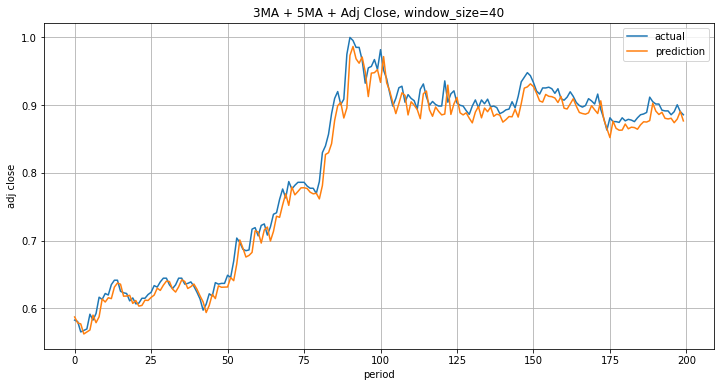

In [23]:
pred = model.predict(x_test)

plt.figure(figsize=(12, 6))
plt.title('3MA + 5MA + Adj Close, window_size=40')
plt.ylabel('adj close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')

plt.show()

In [24]:
print( np.sum(abs(y_test-pred)/y_test) / len(x_test) )

0.01626921290219702
